<a href="https://colab.research.google.com/github/lewisevans38/Suez-Time-Series-Anomaly-Detection-/blob/main/TadGANonNAB_cpc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd

In [ ]:

class Encoder(nn.Module):
    def __init__(self, signal_shape=100, latent_space_dim=20, hyperbolic=False):
        super(Encoder, self).__init__()
        self.signal_shape = signal_shape
        self.latent_space_dim = latent_space_dim
        self.lstm = nn.LSTM(
            input_size=self.signal_shape,
            hidden_size=50,
            num_layers=1,
            bidirectional=True,
        )
        self.dense = nn.Linear(in_features=100, out_features=self.latent_space_dim)

    def forward(self, x):
        x = x.view(1, -1, self.signal_shape).float()
        x, (hn, cn) = self.lstm(x)
        x = self.dense(x)
        return x
class Decoder(nn.Module):
    def __init__(self, signal_shape=100, latent_space_dim=20, hyperbolic=False):
        super(Decoder, self).__init__()
        self.signal_shape = signal_shape
        self.latent_space_dim = latent_space_dim
        self.dense1 = nn.Linear(in_features=self.latent_space_dim, out_features=50)
        self.lstm = nn.LSTM(
            input_size=50, hidden_size=64, num_layers=2, dropout=0.2, bidirectional=True
        )
        self.dense2 = nn.Linear(in_features=128, out_features=self.signal_shape)
        self.tanh = nn.Tanh()
        self.hyperbolic = hyperbolic

    def forward(self, x):
        x = self.dense1(x)
        x, (hn, cn) = self.lstm(x)
        x = self.dense2(x)
        x = self.tanh(x)
        return x

class CriticX(nn.Module):
    def __init__(self, signal_shape=10, latent_space_dim=20):
        super(CriticX, self).__init__()
        self.signal_shape = signal_shape
        self.latent_space_dim = latent_space_dim
        self.dropout = nn.Dropout(p=0.25)
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.dense1 = nn.Linear(
            in_features=self.signal_shape, out_features=self.latent_space_dim
        )
        self.dense2 = nn.Linear(
            in_features=self.latent_space_dim, out_features=self.latent_space_dim
        )
        self.dense3 = nn.Linear(
            in_features=self.latent_space_dim, out_features=self.latent_space_dim
        )
        self.dense4 = nn.Linear(
            in_features=self.latent_space_dim, out_features=self.latent_space_dim
        )
        self.dense5 = nn.Linear(in_features=self.latent_space_dim, out_features=1)

    def forward(self, x):
        x = x.view(1, -1, self.signal_shape).float()
        x = self.dense1(x)
        x = self.leakyrelu(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.leakyrelu(x)
        x = self.dropout(x)
        x = self.dense3(x)
        x = self.leakyrelu(x)
        x = self.dropout(x)
        x = self.dense4(x)
        x = self.leakyrelu(x)
        x = self.dropout(x)
        x = self.dense5(x)
        return x
class CriticZ(nn.Module):
    def __init__(self, latent_space_dim=20):
        super(CriticZ, self).__init__()
        self.latent_space_dim = latent_space_dim
        self.dense1 = nn.Linear(
            in_features=self.latent_space_dim, out_features=self.latent_space_dim
        )
        self.dense2 = nn.Linear(
            in_features=self.latent_space_dim, out_features=self.latent_space_dim
        )
        self.dense3 = nn.Linear(in_features=self.latent_space_dim, out_features=1)
        self.dropout = nn.Dropout(p=0.2)
        self.leakyrelu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.dense1(x)
        x = self.leakyrelu(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.leakyrelu(x)
        x = self.dropout(x)
        x = self.dense3(x)

        return x


def unroll_signal(self, x):
    x = np.array(x).reshape(100)
    return np.median(x)

In [ ]:
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import torch.optim as optim

In [ ]:
def critic_x_iteration(sample, decoder, critic_x, optim_cx, TIME_STEPS):
    optim_cx.zero_grad()
    y = sample.view(1, 1, TIME_STEPS)
    valid_x = torch.squeeze(critic_x(y))

    # The sampled z are the anomalous points - points deviating from actual distribution of z (obtained through encoding x)
    latent_space_dim = 45
    z = torch.Tensor(
        np.random.normal(size=(1, 1,latent_space_dim))
    )
    x_ = decoder(z)

    fake_x = torch.squeeze(critic_x(x_))

    critic_score_valid_x = torch.mean(
        -torch.ones(valid_x.shape) * valid_x
    )  # Wasserstein Loss
    critic_score_fake_x = torch.mean(
        torch.ones(fake_x.shape) * fake_x
    )  # Wasserstein Loss

    real_data = y
    generated_data = x_

    batch_size_ = real_data.size()[0]

    # Calculate interpolation
    alpha = torch.rand(y.shape)
    alpha = alpha.expand_as(real_data)
    alpha = alpha
    interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
    interpolated = Variable(interpolated, requires_grad=True)
    interpolated = interpolated

    # Calculate probability of interpolated examples
    prob_interpolated = critic_x(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(
        outputs=prob_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones(prob_interpolated.size()),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Gradients have shape (batch_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(batch_size_, -1)
    # self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data[0])

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients**2, dim=1) + 1e-12)

    # Return gradient penalty
    gp_loss = ((gradients_norm - 1) ** 2).mean()

    #################################################

    # Critic has to maximize Cx(Valid X) - Cx(Fake X).
    # Maximizing the above is same as minimizing the negative.
    wl = critic_score_fake_x + critic_score_valid_x
    loss = wl + 10 * gp_loss
    loss.backward(retain_graph=True)
    optim_cx.step()

    return loss

In [ ]:
def critic_z_iteration(sample, encoder, critic_z, optim_cz, TIME_STEPS):
    optim_cz.zero_grad()

    x = sample.view(1, 1, TIME_STEPS)
    z_ = encoder(x)

    fake_z = torch.squeeze(critic_z(z_))
    critic_score_fake_z = torch.mean(
        torch.ones(fake_z.shape)* fake_z
    )  # Wasserstein Loss


    latent_space_dim = 45
    z = torch.Tensor(
        np.random.normal(size=(1,1, latent_space_dim))
    )
    valid_z = torch.squeeze(critic_z(z))
    critic_score_valid_z = torch.mean(
        -torch.ones(fake_z.shape) * valid_z
    )  # Wasserstein Loss

    wl = critic_score_fake_z + critic_score_valid_z

    real_data = z
    generated_data = z_

    batch_size_ = real_data.size()[0]

    # Calculate interpolation
    alpha = torch.rand(z.shape)
    alpha = alpha.expand_as(real_data)
    interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
    interpolated = Variable(interpolated, requires_grad=True)
    interpolated = interpolated

    # Calculate probability of interpolated examples
    prob_interpolated = critic_z(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(
        outputs=prob_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones(prob_interpolated.size()),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Gradients have shape (batch_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(batch_size_, -1)
    # self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data[0])

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients**2, dim=1) + 1e-12)

    # Return gradient penalty
    gp_loss = ((gradients_norm - 1) ** 2).mean()

    #################################################

    loss = wl + 10 * gp_loss
    loss.backward(retain_graph=True)
    optim_cz.step()

    return loss

In [ ]:
def decoder_iteration(
    sample,
    encoder,
    decoder,
    critic_x,
    critic_z,
    optim_dec,
    TIME_STEPS,
    err_loss=nn.MSELoss(),
):
    optim_dec.zero_grad()

    x_gen = sample.view(1, 1, TIME_STEPS)
    z_gen_ = encoder(x_gen)
    fake_gen_z = critic_z(z_gen_)

    latent_space_dim = 45
    z_gen = torch.Tensor(
        np.random.normal(size=(1, 1, latent_space_dim))
    )


    x_gen_ = decoder(z_gen)


    fake_gen_x = critic_x(x_gen_)
    critic_score_fake_gen_x = torch.mean(
        -torch.ones(fake_gen_x.shape) * fake_gen_x
    )
    critic_score_fake_gen_z = torch.mean(
        -torch.ones(fake_gen_z.shape) * fake_gen_z
    )

    x_gen_rec = decoder(z_gen_)
    mse_loss = err_loss(x_gen.float(), x_gen_rec.float())
    loss_dec = 10 * mse_loss + critic_score_fake_gen_x + critic_score_fake_gen_z

    loss_dec.backward()
    optim_dec.step()

    return loss_dec, 0, mse_loss


In [ ]:
def train_tadgan(
    train_dataset1,
    encoder,
    decoder,
    critic_x,
    critic_z,
    n_epochs=2000,
    TIME_STEPS = 0,
):
    cx_epoch_loss = list()
    cz_epoch_loss = list()
    encoder_epoch_loss = list()
    decoder_epoch_loss = list()
    hyp_dec_loss = list()
    eucl_dec_loss = list()

    """
    INIT OPTIMIZERS
    """
    # optim_enc = optim.Adam(encoder.parameters(), lr=params.lr, betas=(0.9, 0.999))
    optim_cx = optim.Adam(critic_x.parameters(), lr=1e-6, betas=(0.9, 0.999))
    optim_cz = optim.Adam(critic_z.parameters(), lr=1e-6, betas=(0.9, 0.999))
    # optim_dec = optim.Adam(decoder.parameters(), lr=params.lr, betas=(0.9, 0.999))
    optim_dec = optim.Adam(
        list(decoder.parameters()) + list(encoder.parameters()),
        lr=1e-6,
        betas=(0.9, 0.999),
    )
    actual_epoch = 0


    """
    TRAINING LOOP
    """
    for epoch in range(n_epochs):
        n_critics = 5

        cx_nc_loss = list()
        cz_nc_loss = list()

        for param in decoder.parameters():
            param.requires_grad = False
        for param in encoder.parameters():
            param.requires_grad = False
        for param in critic_x.parameters():
            param.requires_grad = True
        for param in critic_z.parameters():
            param.requires_grad = True

        for i in range(n_critics):
            cx_loss = list()
            cz_loss = list()

            for sample in train_dataset1:
                loss = critic_x_iteration(
                    sample, decoder, critic_x, optim_cx, TIME_STEPS= TIME_STEPS
                )
                cx_loss.append(loss)

                loss = critic_z_iteration(
                    sample, encoder, critic_z, optim_cz, TIME_STEPS = TIME_STEPS
                )
                cz_loss.append(loss)

            cx_nc_loss.append(torch.mean(torch.tensor(cx_loss)))
            cz_nc_loss.append(torch.mean(torch.tensor(cz_loss)))

        for param in decoder.parameters():
            param.requires_grad = True
        for param in encoder.parameters():
            param.requires_grad = True
        for param in critic_x.parameters():
            param.requires_grad = False
        for param in critic_z.parameters():
            param.requires_grad = False
        encoder_loss = list()
        decoder_loss = list()
        hyp_loss = list()
        mse_losss = list()
        for sample in train_dataset1:
            # enc_loss = encoder_iteration(sample.cuda())
            dec_loss, hyper_loss, mse_loss = decoder_iteration(
                sample, encoder, decoder, critic_x, critic_z, optim_dec,TIME_STEPS)
            # encoder_loss.append(enc_loss)
            decoder_loss.append(dec_loss)
            # type: ignore
            mse_losss.append(mse_loss.float())

        cx_epoch_loss.append(torch.mean(torch.tensor(cx_nc_loss)))
        cz_epoch_loss.append(torch.mean(torch.tensor(cz_nc_loss)))
        # encoder_epoch_loss.append(torch.mean(torch.tensor(encoder_loss)))
        decoder_epoch_loss.append(torch.mean(torch.tensor(decoder_loss)))

        eucl_dec_loss.append(torch.mean(torch.tensor(mse_losss)))

        print("Encoder decoder training done in epoch {}".format(epoch))


        print("Eucl mse loss {}".format(eucl_dec_loss[-1]))
        print(
            "critic x loss {:.3f} critic z loss {:.3f} \ndecoder loss {:.3f}\n".format(
                cx_epoch_loss[-1], cz_epoch_loss[-1], decoder_epoch_loss[-1]
            )
        )

        actual_epoch += 1

In [ ]:
def train1(epochs, train_loader, TIME_STEPS):
    """
    MODEL INITIALIZATION
    """
    latent_space_dim = 45
    print("w")
    encoder = (
        Encoder(TIME_STEPS, latent_space_dim).train()
    )
    decoder = (
       Decoder(TIME_STEPS, latent_space_dim,)

        .train()
    )
    critic_x = (
       CriticX(TIME_STEPS, latent_space_dim).train()
    )
    critic_z =CriticZ(latent_space_dim).train()

    """
    TRAIN
    """
    train_tadgan(
        train_loader,
        encoder,
        decoder,
        critic_x,
        critic_z,
        n_epochs=epochs,
        TIME_STEPS = TIME_STEPS
    )
    return encoder, decoder, critic_x, critic_z

All of this code has come from the following github https://github.com/aleflabo/HypAD/blob/main/main.py, who are people that try to improve upon the TadGAN. I intend to only use the TadGAN section, so I have removed the hyperbolic additions where neccesary. I have also made changes so that the code can work with my specific dataset.  


In [ ]:
URL1= "https://raw.githubusercontent.com/numenta/NAB/master/data/realAdExchange/exchange-2_cpc_results.csv"
URL2 = "https://raw.githubusercontent.com/numenta/NAB/master/data/realAdExchange/exchange-3_cpc_results.csv"

DATA1 = pd.read_csv(URL1)
DATA2 = pd.read_csv(URL2)

df  = DATA1
df2 = DATA2

train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range =(-1,1))
scaler = scaler.fit(train[['value']])
train['value'] = scaler.transform(train[['value']])
test['value'] = scaler.transform(test[['value']])
df['value'] = scaler.transform(df[['value']])
df2['value'] = scaler.transform(df2[['value']])

def create_dataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)
TIME_STEPS = 6
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(
  train[['value']],
  train.value,
  TIME_STEPS
)
X_test, y_test = create_dataset(
  test[['value']],
  test.value,
  TIME_STEPS
)

##Turn into pytorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

from torch.utils.data import Dataset

from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
  def __init__(self, X,y):
    self.X = X
    self.y = y

  def __len__(self):
    return(len(self.X))

  def __getitem__(self , i):
    return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

(1542, 2) (82, 2)


<ipython-input-33-a952b78fbb27>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['value'] = scaler.transform(train[['value']])
<ipython-input-33-a952b78fbb27>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['value'] = scaler.transform(test[['value']])


In [ ]:
e, d, cx, cz = train1(90, X_train, TIME_STEPS)

w
Encoder decoder training done in epoch 0
Eucl mse loss 0.17522214353084564
critic x loss 9.208 critic z loss 7.557 
decoder loss 1.733

Encoder decoder training done in epoch 1
Eucl mse loss 0.17233650386333466
critic x loss 8.771 critic z loss 6.879 
decoder loss 1.717

Encoder decoder training done in epoch 2
Eucl mse loss 0.16943909227848053
critic x loss 7.963 critic z loss 6.006 
decoder loss 1.698

Encoder decoder training done in epoch 3
Eucl mse loss 0.1665765643119812
critic x loss 6.733 critic z loss 4.946 
decoder loss 1.673

Encoder decoder training done in epoch 4
Eucl mse loss 0.1637439727783203
critic x loss 5.040 critic z loss 3.797 
decoder loss 1.648

Encoder decoder training done in epoch 5
Eucl mse loss 0.1610126495361328
critic x loss 3.180 critic z loss 2.648 
decoder loss 1.600

Encoder decoder training done in epoch 6
Eucl mse loss 0.15833914279937744
critic x loss 1.598 critic z loss 1.688 
decoder loss 1.560

Encoder decoder training done in epoch 7
Eucl mse

In [ ]:
predictions = []
with torch.no_grad():
  for seq_true in X_train:
    predictions.append(d(e(seq_true))[:][0][0][-1].item())

In [ ]:
predictions[:5]

[-0.33917203545570374,
 -0.2768256962299347,
 -0.23411911725997925,
 -0.13150142133235931,
 -0.04749659448862076]

In [ ]:
import matplotlib.pyplot as plt

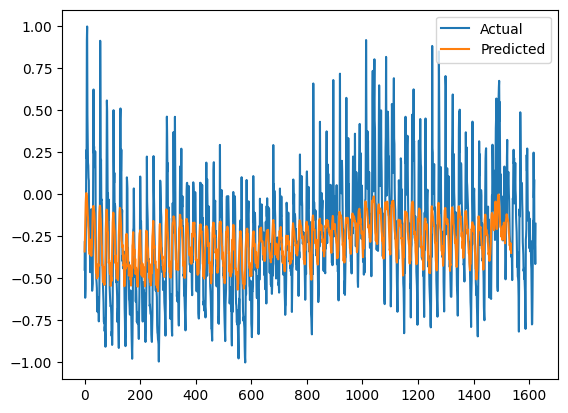

In [ ]:
plt.plot(df['value'], label = 'Actual')
plt.plot(predictions, label ='Predicted')
plt.legend()
plt.show()

Setting up the anomaly detection mechanism. The idea is to find pointwise-difference reconstruction errors, as well as compute a critic score for each sequence.

In [ ]:
URL2 = "https://raw.githubusercontent.com/numenta/NAB/master/data/realAdExchange/exchange-3_cpc_results.csv"
df2 = pd.read_csv(URL2).set_index('timestamp')

In [ ]:
##Seeing how the model predicts on the anomalous data sets.

##Creating Datasets

df2_test , _= create_dataset(df2['value'] , df2.value, 6)
##Turn into tensors
df2_test = torch.tensor(df2_test).float()

##Predictions
predictions1 = []
critic_score = []
with torch.no_grad():
  for seq_true in df2_test:
    predictions1.append(d(e(seq_true))[:][0][0][-1].item())

##Computing critic score for each sequence
with torch.no_grad():
  for seq_true in df2_test:
    critic_score.append(cx(seq_true))


In [ ]:
##Computing pointwise difference Xc
indextracker = []
difference = []
for x in range(0,len(predictions1)):
  diff = abs(df2['value'][x] - predictions1[x])
  difference.append(diff)


In [ ]:
from scipy import stats
Z_RE = stats.zscore(difference)
Z_cx = stats.zscore(critic_score)

#taking z_scores

In [ ]:
true_errors = []
for x in range(len(Z_RE)):
  true_errors.append(abs(Z_RE[x]*Z_cx[x]))

standard_deviation = np.std(true_errors)
Mean = np.mean(true_errors)
for x in range (0,len(true_errors)):
 if true_errors[x] >1*standard_deviation+ Mean:
    indextracker.append(x)
print("The anomalous points are at" , indextracker)
print("The total amount of anomalies is", len(indextracker))

The anomalous points are at [22, 23, 36, 59, 60, 86, 87, 120, 169, 173, 226, 293, 295, 296, 297, 435, 436, 437, 438, 439, 708, 956, 976, 978, 979, 980, 1118, 1121, 1334, 1358, 1377, 1419, 1433, 1443, 1446, 1468, 1489, 1490, 1491]
The total amount of anomalies is 39


In [ ]:
DATA2 = pd.read_csv(URL2)
DATA2

,timestamp,value
0,2011-07-01 00:15:01,0.102709
1,2011-07-01 01:15:01,0.068039
2,2011-07-01 02:15:01,0.077994
3,2011-07-01 03:15:01,0.077682
4,2011-07-01 04:15:01,0.077966
...,...,...
1533,2011-09-07 10:15:01,0.292129
1534,2011-09-07 11:15:01,0.343198
1535,2011-09-07 12:15:01,0.153217
1536,2011-09-07 13:15:01,0.151583


In [ ]:
for x in range(0,len(indextracker)):
  print(DATA2.iloc[indextracker[x]]['timestamp'])

2011-07-01 22:15:01
2011-07-01 23:15:01
2011-07-02 12:15:01
2011-07-03 11:15:01
2011-07-03 12:15:01
2011-07-04 14:15:01
2011-07-04 15:15:01
2011-07-06 00:15:01
2011-07-08 06:15:01
2011-07-08 16:15:01
2011-07-11 12:15:01
2011-07-14 07:15:01
2011-07-14 09:15:01
2011-07-14 10:15:01
2011-07-14 11:15:01
2011-07-20 07:15:01
2011-07-20 08:15:01
2011-07-20 09:15:01
2011-07-20 10:15:01
2011-07-20 11:15:01
2011-08-01 12:15:01
2011-08-12 11:15:01
2011-08-13 09:15:01
2011-08-13 11:15:01
2011-08-13 12:15:01
2011-08-13 13:15:01
2011-08-19 14:15:01
2011-08-19 18:15:01
2011-08-29 12:15:01
2011-08-30 12:15:01
2011-08-31 09:15:01
2011-09-02 10:15:01
2011-09-03 00:15:01
2011-09-03 10:15:01
2011-09-03 13:15:01
2011-09-04 11:15:01
2011-09-05 10:15:01
2011-09-05 11:15:01
2011-09-05 12:15:01


Checking back with the benchmark, apparently there are three anomalies. At time,

2011-07-14 10:15:01",

"2011-07-20 10:15:01",

"2011-08-13 10:15:01

So we have caught two of the three, and we have 37 false anomalies.